<a href="https://colab.research.google.com/github/Samyuktha-cvr/RainRemoval/blob/main/DeRain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()  # Select your .zip file

Saving archive (3).zip to archive (3).zip


In [2]:
import zipfile
import os

zip_path = "/content/archive (3).zip"  # replace with your uploaded file name

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/extracted_images")


In [3]:
from PIL import Image
import glob

input_folder = "/content/extracted_images"
output_folder = "/content/jpg_images"
os.makedirs(output_folder, exist_ok=True)

for filepath in glob.glob(f"{input_folder}/*"):
    try:
        with Image.open(filepath) as img:
            rgb_im = img.convert("RGB")
            base = os.path.basename(filepath)
            name, _ = os.path.splitext(base)
            rgb_im.save(f"{output_folder}/{name}.jpg", "JPEG")
    except Exception as e:
        print(f"Error converting {filepath}: {e}")


In [4]:
!pip install torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
import torch
import torch.nn as nn
import itertools
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
#  Generator: ResNet style
# ------------------------
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residuals=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsample
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        # Residual blocks
        for _ in range(num_residuals):
            model += [ResidualBlock(in_features)]
        # Upsample
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        # Output
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# -----------------------
#  Discriminator: PatchGAN
# -----------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_c, out_c, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),  # shift for output size
            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [9]:
source_dir = "/content/extracted_images"


In [10]:
import os
import shutil
import random

# Path where all images are currently stored
source_dir = "//content/jpg_images"

# Output folders
rain_dir = "/content/dataset/rainy/images"
clean_dir = "/content/dataset/clean/images"

# Create output directories if they don't exist
os.makedirs(rain_dir, exist_ok=True)
os.makedirs(clean_dir, exist_ok=True)

# List all image files (add more extensions if needed)
all_images = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Debug: Check if any images found
print(f"Found {len(all_images)} images in '{source_dir}'")

# Shuffle and split 50/50
random.shuffle(all_images)
mid = len(all_images) // 2
rainy_files = all_images[:mid]
clean_files = all_images[mid:]

# Move rainy images
for f in rainy_files:
    shutil.move(os.path.join(source_dir, f), os.path.join(rain_dir, f))
    print(f"Moved to RAINY: {f}")

# Move clean images
for f in clean_files:
    shutil.move(os.path.join(source_dir, f), os.path.join(clean_dir, f))
    print(f"Moved to CLEAN: {f}")

# Summary
print("\n==== SPLIT COMPLETED ====")
print(f"Rainy images: {len(rainy_files)}")
print(f"Clean images: {len(clean_files)}")


Found 400 images in '//content/jpg_images'
Moved to RAINY: rainregion-089.jpg
Moved to RAINY: rainregion-030.jpg
Moved to RAINY: rainregion-069.jpg
Moved to RAINY: rainregion-027.jpg
Moved to RAINY: norain-028.jpg
Moved to RAINY: rain-099.jpg
Moved to RAINY: norain-027.jpg
Moved to RAINY: rainstreak-062.jpg
Moved to RAINY: norain-052.jpg
Moved to RAINY: rainstreak-020.jpg
Moved to RAINY: rainstreak-048.jpg
Moved to RAINY: rain-028.jpg
Moved to RAINY: rainstreak-093.jpg
Moved to RAINY: rain-070.jpg
Moved to RAINY: rain-080.jpg
Moved to RAINY: norain-081.jpg
Moved to RAINY: rainregion-095.jpg
Moved to RAINY: rainregion-080.jpg
Moved to RAINY: rainstreak-058.jpg
Moved to RAINY: rain-071.jpg
Moved to RAINY: rainregion-083.jpg
Moved to RAINY: rain-079.jpg
Moved to RAINY: rain-001.jpg
Moved to RAINY: norain-032.jpg
Moved to RAINY: rainstreak-002.jpg
Moved to RAINY: rainregion-062.jpg
Moved to RAINY: norain-043.jpg
Moved to RAINY: rainstreak-005.jpg
Moved to RAINY: rain-040.jpg
Moved to RAINY

In [11]:
import torch
import torch.nn as nn

# Basic block for the generator (Residual block)
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator: ResNet-based
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residuals=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsampling
        in_features = 64
        for _ in range(2):
            out_features = in_features * 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        # Residual blocks
        for _ in range(n_residuals):
            model += [ResidualBlock(in_features)]
        # Upsampling
        for _ in range(2):
            out_features = in_features // 2
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Discriminator: PatchGAN
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def conv_block(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *conv_block(in_channels, 64, normalize=False),
            *conv_block(64, 128),
            *conv_block(128, 256),
            *conv_block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [12]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# Transform for resizing and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Unpaired datasets
dataset_rain = datasets.ImageFolder('/content/dataset/rainy', transform=transform)
dataset_clean = datasets.ImageFolder('/content/dataset/clean', transform=transform)

loader_rain = DataLoader(dataset_rain, batch_size=1, shuffle=True)
loader_clean = DataLoader(dataset_clean, batch_size=1, shuffle=True)


In [15]:
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_AB = Generator().to(device)  # Rain → Clean
G_BA = Generator().to(device)  # Clean → Rain
D_A = Discriminator().to(device)  # Discriminator for Rain
D_B = Discriminator().to(device)  # Discriminator for Clean

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

lr = 0.0002
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

# Start training
num_epochs = 10  # Increase to 100+ for better quality
for epoch in range(num_epochs):
    for (data_rain, _), (data_clean, _) in zip(loader_rain, loader_clean):
        real_A = data_rain.to(device)
        real_B = data_clean.to(device)

        # Train Generators
        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))

        recovered_A = G_BA(fake_B)
        recovered_B = G_AB(fake_A)

        loss_cycle_A = criterion_cycle(recovered_A, real_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_B)

        loss_G = loss_GAN_AB + loss_GAN_BA + 10.0 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator A
        optimizer_D_A.zero_grad()
        loss_D_A = (criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A))) +
                    criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B
        optimizer_D_B.zero_grad()
        loss_D_B = (criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B))) +
                    criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_G: {loss_G.item():.4f}, D_A: {loss_D_A.item():.4f}, D_B: {loss_D_B.item():.4f}")


Epoch [1/10] Loss_G: 14.7754, D_A: 0.1138, D_B: 0.0366
Epoch [2/10] Loss_G: 8.8963, D_A: 0.0111, D_B: 0.0121
Epoch [3/10] Loss_G: 21.4657, D_A: 0.0794, D_B: 0.1536
Epoch [4/10] Loss_G: 6.6502, D_A: 0.0529, D_B: 0.0132
Epoch [5/10] Loss_G: 16.1561, D_A: 0.0447, D_B: 0.0597
Epoch [6/10] Loss_G: 7.3279, D_A: 0.0868, D_B: 0.0215
Epoch [7/10] Loss_G: 9.3635, D_A: 0.0167, D_B: 0.0274
Epoch [8/10] Loss_G: 10.6392, D_A: 0.0704, D_B: 0.0101
Epoch [9/10] Loss_G: 7.0746, D_A: 0.1643, D_B: 0.0111
Epoch [10/10] Loss_G: 8.7088, D_A: 0.0378, D_B: 0.0051


In [16]:
torch.save(G_AB.state_dict(), "derain_generator.pth")
print("✅ Trained model saved.")


✅ Trained model saved.


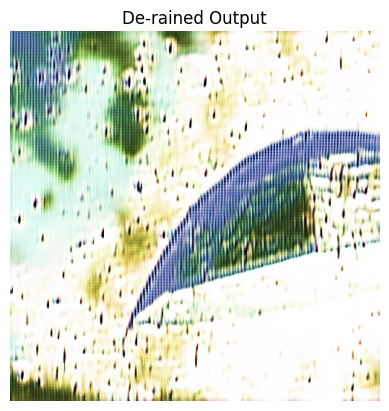

In [20]:
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Load and preprocess image
image_path = '/content/Rain.1.jpg'  # Replace with your test image
img = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

input_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 512, 512]

# Inference
G_AB.eval()
with torch.no_grad():
    output = G_AB(input_tensor).squeeze(0).cpu()
    output = output * 0.5 + 0.5  # Denormalize
    plt.imshow(output.permute(1, 2, 0))  # Convert to [H, W, C]
    plt.title("De-rained Output")
    plt.axis("off")
    plt.show()


In [24]:
import torch
import torch.nn as nn

# === Define ResNet block ===
class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            norm_layer(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            norm_layer(dim)
        )

    def forward(self, x):
        return x + self.conv_block(x)

# === Define Generator ===
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=9):
        super().__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
            norm_layer(ngf),
            nn.ReLU(True)
        ]

        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)
            ]

        # ResNet blocks
        mult = 2 ** n_downsampling
        for _ in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                   kernel_size=3, stride=2,
                                   padding=1, output_padding=1),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


In [26]:
checkpoint = torch.load('/content/derain_generator.pth', map_location='cpu')
for k in checkpoint.keys():
    print(k)


model.1.weight
model.1.bias
model.4.weight
model.4.bias
model.7.weight
model.7.bias
model.10.block.1.weight
model.10.block.1.bias
model.10.block.5.weight
model.10.block.5.bias
model.11.block.1.weight
model.11.block.1.bias
model.11.block.5.weight
model.11.block.5.bias
model.12.block.1.weight
model.12.block.1.bias
model.12.block.5.weight
model.12.block.5.bias
model.13.block.1.weight
model.13.block.1.bias
model.13.block.5.weight
model.13.block.5.bias
model.14.block.1.weight
model.14.block.1.bias
model.14.block.5.weight
model.14.block.5.bias
model.15.block.1.weight
model.15.block.1.bias
model.15.block.5.weight
model.15.block.5.bias
model.16.block.1.weight
model.16.block.1.bias
model.16.block.5.weight
model.16.block.5.bias
model.17.block.1.weight
model.17.block.1.bias
model.17.block.5.weight
model.17.block.5.bias
model.18.block.1.weight
model.18.block.1.bias
model.18.block.5.weight
model.18.block.5.bias
model.19.weight
model.19.bias
model.22.weight
model.22.bias
model.26.weight
model.26.bia

In [27]:
import torch
import torch.nn as nn

# === Custom Resnet Block matching your checkpoint ===
class ResnetBlock_Modified(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

# === Final Generator that matches your .pth file ===
class MatchedResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),

            # Downsampling
            nn.Conv2d(ngf, ngf*2, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(ngf*2),
            nn.ReLU(True),

            nn.Conv2d(ngf*2, ngf*4, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(ngf*4),
            nn.ReLU(True)
        ]

        # 9 ResNet blocks using your modified version
        for _ in range(9):
            model += [ResnetBlock_Modified(ngf*4)]

        # Upsampling
        model += [
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [29]:
from torchvision import transforms
from PIL import Image
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
netG = MatchedResnetGenerator().to(device)
netG.load_state_dict(torch.load('/content/derain_generator.pth', map_location=device))
netG.eval()
print("✅ Model loaded successfully.")

# Load rainy image
input_image = Image.open('/content/Rain.1.jpg').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

input_tensor = transform(input_image).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    output = netG(input_tensor)
    output = (output.squeeze().cpu().clamp(-1, 1) + 1) / 2

# Save image
to_pil = transforms.ToPILImage()
result = to_pil(output)
result.save('/content/derained_output.jpg')
print("✅ Derained image saved.")


✅ Model loaded successfully.
✅ Derained image saved.


In [30]:
import cv2
import numpy as np
from PIL import Image

# Load the derained image
img = cv2.imread('/content/derained_output.jpg')

# Convert to LAB color space for CLAHE
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# Apply CLAHE to L-channel
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
cl = clahe.apply(l)

# Merge channels back
limg = cv2.merge((cl, a, b))
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Apply sharpening filter
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(enhanced_img, -1, kernel)

# Save enhanced image
cv2.imwrite('/content/derained_enhanced.jpg', sharpened)
print("✅ Enhanced derained image saved: /content/derained_enhanced.jpg")


✅ Enhanced derained image saved: /content/derained_enhanced.jpg


In [32]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np

# Load ground truth and predicted images
gt = Image.open('/content/Rain.1.jpg').convert('RGB').resize((256, 256))
pred = Image.open('/content/derained_enhanced.jpg').convert('RGB').resize((256, 256))

gt_np = np.array(gt)
pred_np = np.array(pred)

# Compute PSNR
psnr_score = psnr(gt_np, pred_np)

# Compute SSIM (updated for latest scikit-image)
ssim_score = ssim(gt_np, pred_np, channel_axis=-1, win_size=7)

print(f"📈 PSNR: {psnr_score:.2f} dB")
print(f"📊 SSIM: {ssim_score:.4f}")


📈 PSNR: 4.79 dB
📊 SSIM: -0.0379
